# Fine-Tuning ResNet-152 on CIFAR-10
This notebook fine-tunes Microsoft's ResNet-152 model on the CIFAR-10 dataset.

### Objectives:
1. Load and preprocess the CIFAR-10 dataset.
2. Fine-tune the ResNet-152 model.
3. Evaluate the model's performance.


In [1]:
# Install necessary libraries
!pip install transformers datasets torch torchvision matplotlib scikit-learn

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Import libraries
import numpy as np
import torch
import torch.nn as nn
from transformers import AutoModelForImageClassification, AutoImageProcessor
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

## Loading the Pretrained ResNet-152 Model
We use the `transformers` library to load Microsoft's ResNet-152 model. The model is initialized with pre-trained weights and fine-tuned on CIFAR-10.

In [3]:
model_name = 'microsoft/resnet-152'
model = AutoModelForImageClassification.from_pretrained(model_name)
processor = AutoImageProcessor.from_pretrained(model_name)

## Loading and Preprocessing the CIFAR-10 Dataset
In this section, we load the CIFAR-10 dataset using PyTorch's `torchvision.datasets`. We also apply transformations to preprocess the images for training the ResNet-152 model.

In [4]:
# Define CIFAR-10 data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])

# Load CIFAR-10 dataset
from torchvision.datasets import CIFAR10
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

# Extract labels from the train_dataset
train_labels = np.array([label for _, label in train_dataset])

# Stratified split using train_test_split from sklearn
train_indices, val_indices = train_test_split(
    np.arange(len(train_labels)),
    test_size=0.2,  # 20% validation split
    stratify=train_labels,  # Ensure class balance
    random_state=42
)

# Create subsets for training and validation
train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(train_dataset, val_indices)

In [6]:
# Prepare DataLoaders
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [7]:
# Modify the classifier for CIFAR-10 (10 classes)
if isinstance(model.classifier, nn.Sequential):  # If the classifier is Sequential
    num_features = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(num_features, 10)
else:  # If it's a simple Linear layer
    num_features = model.classifier.in_features
    model.classifier = nn.Linear(num_features, 10)

## Fine-Tuning the Model
In this section, we train the model on the CIFAR-10 training dataset using the Adam optimizer. The training loop computes the loss, performs backpropagation, and updates the weights.

In [8]:
from torch.optim import AdamW
from torch.nn.functional import cross_entropy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)  # Ensure loss is computed on the same device
optimizer = AdamW(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 15
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU/CPU 

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.logits, labels)  # Use outputs.logits for Hugging Face models

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average training loss
    avg_train_loss = running_loss / len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # No gradient computation for validation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU/CPU 

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs.logits, labels)

            val_loss += loss.item()

            # Calculate accuracy
            _, preds = torch.max(outputs.logits, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    # Calculate average validation loss and accuracy
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, "
          f"Val Accuracy: {val_accuracy:.4f}")

Epoch 1/15, Train Loss: 2.0190, Val Loss: 1.5484, Val Accuracy: 0.4667
Epoch 2/15, Train Loss: 1.3293, Val Loss: 1.1013, Val Accuracy: 0.6092
Epoch 3/15, Train Loss: 0.9933, Val Loss: 0.8929, Val Accuracy: 0.6861
Epoch 4/15, Train Loss: 0.8042, Val Loss: 0.8072, Val Accuracy: 0.7169
Epoch 5/15, Train Loss: 0.6621, Val Loss: 0.7411, Val Accuracy: 0.7425
Epoch 6/15, Train Loss: 0.5367, Val Loss: 0.6936, Val Accuracy: 0.7623
Epoch 7/15, Train Loss: 0.4518, Val Loss: 0.6705, Val Accuracy: 0.7779
Epoch 8/15, Train Loss: 0.3612, Val Loss: 0.6735, Val Accuracy: 0.7802
Epoch 9/15, Train Loss: 0.3019, Val Loss: 0.6758, Val Accuracy: 0.7889
Epoch 10/15, Train Loss: 0.2453, Val Loss: 0.6922, Val Accuracy: 0.7939
Epoch 11/15, Train Loss: 0.2064, Val Loss: 0.7285, Val Accuracy: 0.7957
Epoch 12/15, Train Loss: 0.1862, Val Loss: 0.7508, Val Accuracy: 0.7911
Epoch 13/15, Train Loss: 0.1653, Val Loss: 0.7468, Val Accuracy: 0.7968
Epoch 14/15, Train Loss: 0.1325, Val Loss: 0.7870, Val Accuracy: 0.7994
E

## Evaluating the Model
We evaluate the fine-tuned model on the test dataset by calculating accuracy, precision, recall and visualizing a confusion matrix.

In [9]:
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  
        outputs = model(inputs)
        _, predicted = torch.max(outputs.logits, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Save the trained model
torch.save(model.state_dict(), "resnet152_cifar10_mps.pth")
print("Model saved as resnet152_cifar10_mps.pth")
print(classification_report(all_labels, all_preds))

Model saved as resnet152_cifar10_mps.pth
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      1000
           1       0.86      0.88      0.87      1000
           2       0.74      0.76      0.74      1000
           3       0.65      0.64      0.64      1000
           4       0.77      0.76      0.77      1000
           5       0.72      0.73      0.72      1000
           6       0.84      0.85      0.84      1000
           7       0.84      0.83      0.84      1000
           8       0.91      0.89      0.90      1000
           9       0.86      0.87      0.87      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



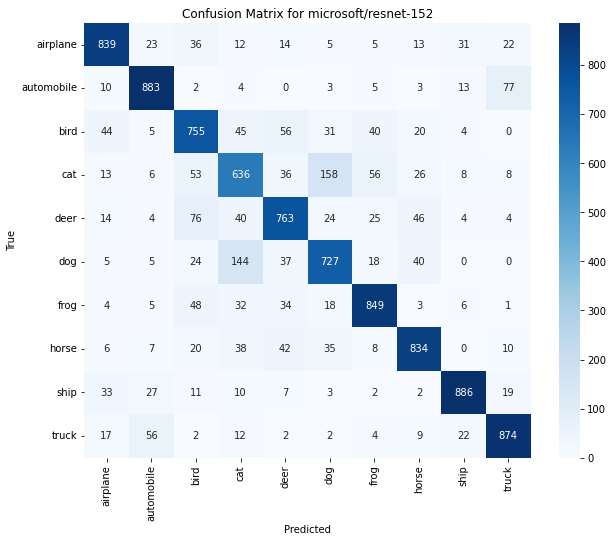

In [10]:
# Visualize the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes,yticklabels=test_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix for {model_name}')
plt.show()

## Visualizing Predictions on Test Dataset
This section displays some sample images from the test dataset along with their predicted labels.

The purpose is to qualitatively assess the model's performance.

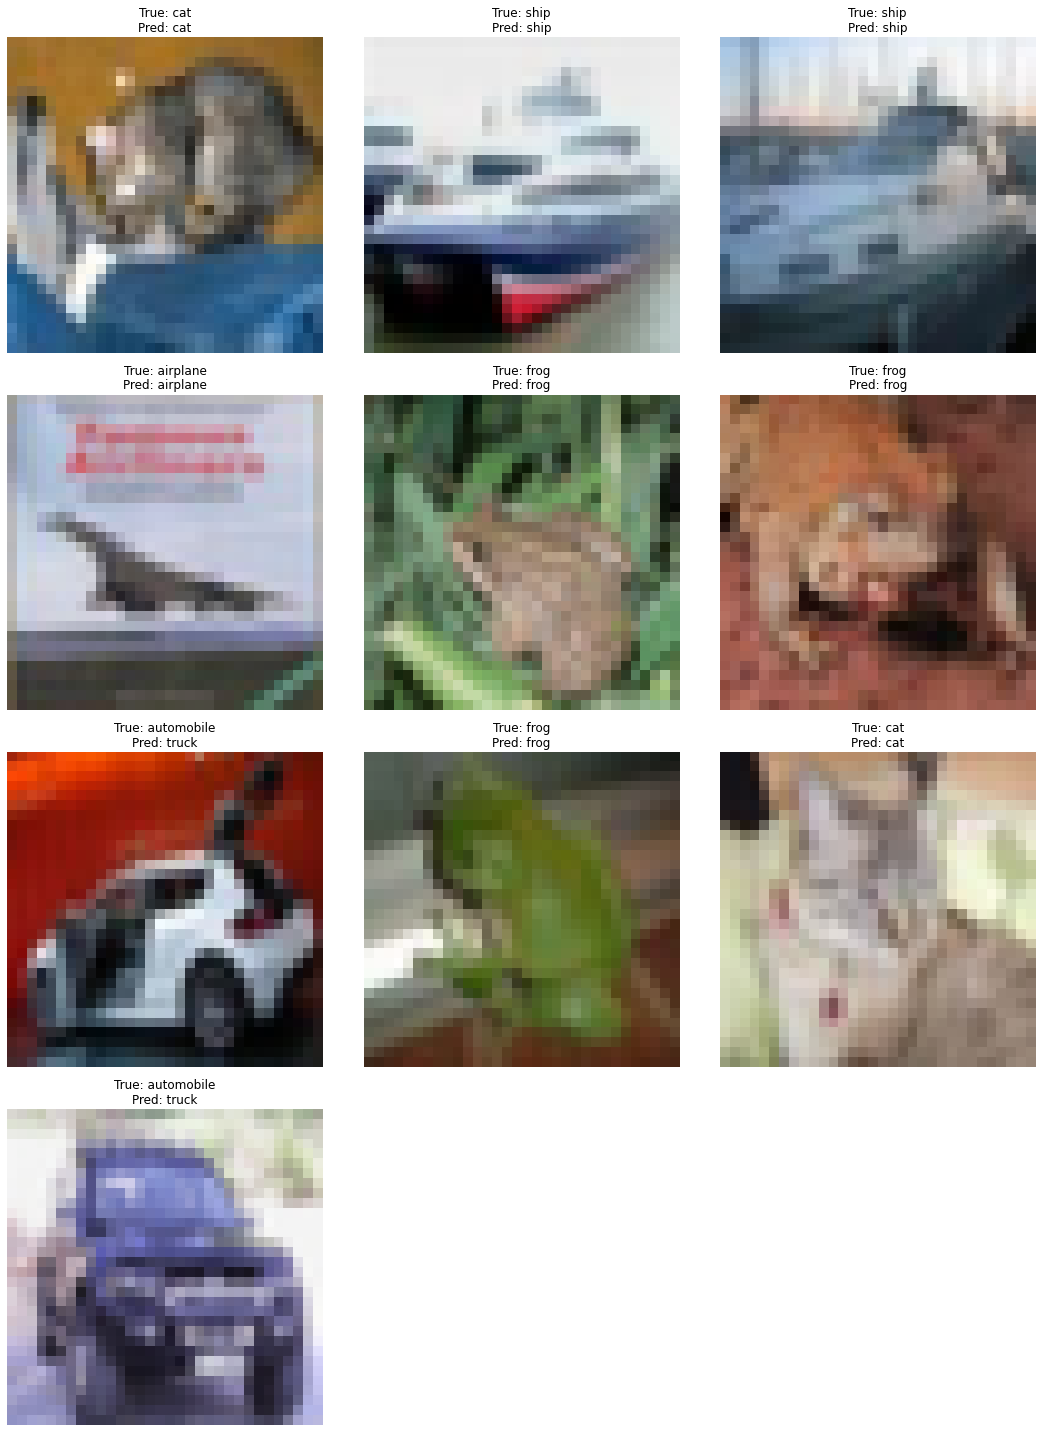

In [11]:
import numpy as np

# Function to display test images with predicted labels
def show_predictions(model, dataset, num_samples=10, max_per_row=3):
    """
    Displays sample images from the dataset along with their true and predicted labels.

    Args:
        model: The trained model for prediction.
        dataset: The dataset to sample images from.
        num_samples: Total number of samples to display.
        max_per_row: Maximum number of images per row.
    """
    model.eval()  # Set the model to evaluation mode
    images, true_labels, pred_labels = [], [], []
    
    with torch.no_grad():
        for i in range(num_samples):
            # Get an image and its label
            image, label = dataset[i]
            images.append(image)
            true_labels.append(label)

            # Predict the label
            input_image = image.unsqueeze(0).to(device)  # Add batch dimension
            output = model(input_image)
            pred_label = torch.argmax(output.logits, dim=1).item()
            pred_labels.append(pred_label)
    
    # Calculate the number of rows needed
    num_rows = (num_samples + max_per_row - 1) // max_per_row  # Ceiling division

    # Plot the images with their labels
    fig, axes = plt.subplots(num_rows, max_per_row, figsize=(max_per_row * 5, num_rows * 5))
    axes = axes.flatten() if num_rows > 1 else [axes]  # Ensure axes is iterable

    for idx, ax in enumerate(axes):
        if idx < num_samples:
            img = images[idx].permute(1, 2, 0).cpu().numpy()  # Convert tensor to numpy
            img = (img * 0.5) + 0.5  # Unnormalize
            ax.imshow(img)
            ax.axis("off")
            ax.set_title(f"True: {dataset.classes[true_labels[idx]]}\nPred: {dataset.classes[pred_labels[idx]]}")
        else:
            ax.axis("off")  # Hide empty subplots

    plt.tight_layout()
    plt.show()


# Display predictions for 10 random test samples
show_predictions(model, test_dataset, num_samples=10)
